# CORDEX-CORE urban vs rural vicinity analysis

## Load libraries

Here we load the required libraries to execute the notebook. Note that specific code from dedicated scripts (`utils.py`, `urban_areas.py`, ...) is also loaded here.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import glob
import numpy as np
import xarray as xr
import cf_xarray as cfxr
from pathlib import Path
import cftime
import pandas as pd
import matplotlib
from pprint import pprint

from urclimask.urban_areas import (
    UrbanVicinity
)
from urclimask.UHI_plot_functions import (
    plot_climatology,
    plot_annual_cycle
)
from urclimask.utils import (
    kelvin2degC,
    traverseDir,
    fix_360_longitudes,
    RCM_DICT,
    load_ucdb_city
)
from urclimask.UHI_analysis import UrbanIsland

from urclimask.GHCNd_stations import (
    load_ghcnd_stations,
    get_ghcnd_df,
    get_valid_timeseries,
    available_vars,
    inside_city
)

## Input parameters

These parameters define the behaviour of the notebook, by selecting the `city`, `variable`, and some other items which are mostly self-explanatory. _(Explain here those with are not)_

This cell is tagged `parameters`, in order to be managed externally by the [`papermill` package](https://papermill.readthedocs.io/en/latest).

In [46]:
city = 'Paris'
lon_city = 2.35
lat_city = 48.85

domain = 'EUR-22'
model = 'REMO'
scenario = "evaluation"

urban_var = 'sftimf'

urban_th = 10
urban_sur_th = 10
orog_diff = 100
sftlf_th = 70
scale = 2
min_city_size = 10
lon_lim = 1
lat_lim = 1

variable = 'tasmin'

Create a directory to save the results for this particular city and model

Create a directory to save the results for this particular city and model

In [21]:
base_output_dir = 'results'
output_dir = f"{base_output_dir}/{city}-{domain}_{RCM_DICT[domain][model]}"
os.makedirs(output_dir, exist_ok = True)

Infer doman resolution in degrees and create filename

In [22]:
domain_resolution = int(domain.split('-')[1])
base_filename = f'{city}-{domain}_ECMWF-ERA5_{scenario}_r1i1p1f1_{RCM_DICT[domain][model]}'

## Define urban areas and vicinity

### Load static variables
Load static variables, such as urban fraction (sfturf), terrain elevation (orography) or land-sea fraction (sftlf).

In [23]:
root_nextcloud = '/lustre/gmeteo/WORK/DATA/CORDEX-FPS-URB-RCC/nextcloud/CORDEX-CORE-WG/'
root_esgf = "/lustre/gmeteo/DATA/ESGF/REPLICA/DATA/cordex/output/"

In [24]:
file_sfturf = glob.glob(
        f"{root_nextcloud}{model}/{urban_var}/{urban_var}_{domain}*.nc" 
)

file_orog = glob.glob(
    f"{root_esgf}{domain}/{RCM_DICT[domain][model].split('_')[0]}/ECMWF-ERAINT/evaluation/*/{RCM_DICT[domain][model].split('_')[1]}/*/fx/orog/*/orog_*.nc" 
)
file_sftlf = glob.glob(
    f"{root_esgf}{domain}/{RCM_DICT[domain][model].split('_')[0]}/ECMWF-ERAINT/evaluation/*/{RCM_DICT[domain][model].split('_')[1]}/*/fx/sftlf/*/sftlf_*.nc" 
)

In [25]:
ds_sfturf = xr.open_dataset(file_sfturf[0])
ds_orog = xr.open_dataset(file_orog[0])
ds_sftlf = xr.open_dataset(file_sftlf[0])

ds_sfturf = fix_360_longitudes(ds_sfturf)
ds_orog = fix_360_longitudes(ds_orog)
ds_sftlf = fix_360_longitudes(ds_sftlf)

Add parameters to the function

In [26]:
URBAN = UrbanVicinity(
    urban_sur_th = urban_sur_th,
    orog_diff = orog_diff,
    sftlf_th = sftlf_th,
    scale = scale,
    min_city_size = min_city_size,
    lon_city = lon_city,
    lat_city = lat_city,
    lon_lim = lon_lim,
    lat_lim = lat_lim,
    model = model,
    domain = domain,
    urban_th = urban_th,
    urban_var = urban_var
)

Crop area around de city

In [27]:
ds_sfturf = URBAN.crop_area_city(ds = ds_sfturf, res = domain_resolution)
ds_orog = URBAN.crop_area_city(ds = ds_orog, res = domain_resolution)
ds_sftlf = URBAN.crop_area_city(ds = ds_sftlf, res = domain_resolution)

Define masks using the parameters above

In [ ]:
sfturf_mask, sfturf_sur_mask, orog_mask, sftlf_mask = URBAN.define_masks(
    ds_sfturf = ds_sfturf, 
    ds_orog = ds_orog, 
    ds_sftlf = ds_sftlf,
)

### Define rural vicinity areas

We use an iterative algorithm to select the urban vicinity excluding masked areas

In [29]:
urmask = URBAN.select_urban_vicinity(
    sfturf_mask = sfturf_mask, 
    orog_mask = orog_mask,
    sftlf_mask = sftlf_mask,
    sfturf_sur_mask = sfturf_sur_mask
)

We can plot the masks and the urban vs vicinity areas. The latter are are passed via the `urban_areas` parameter. They are hidden if set to `None`.

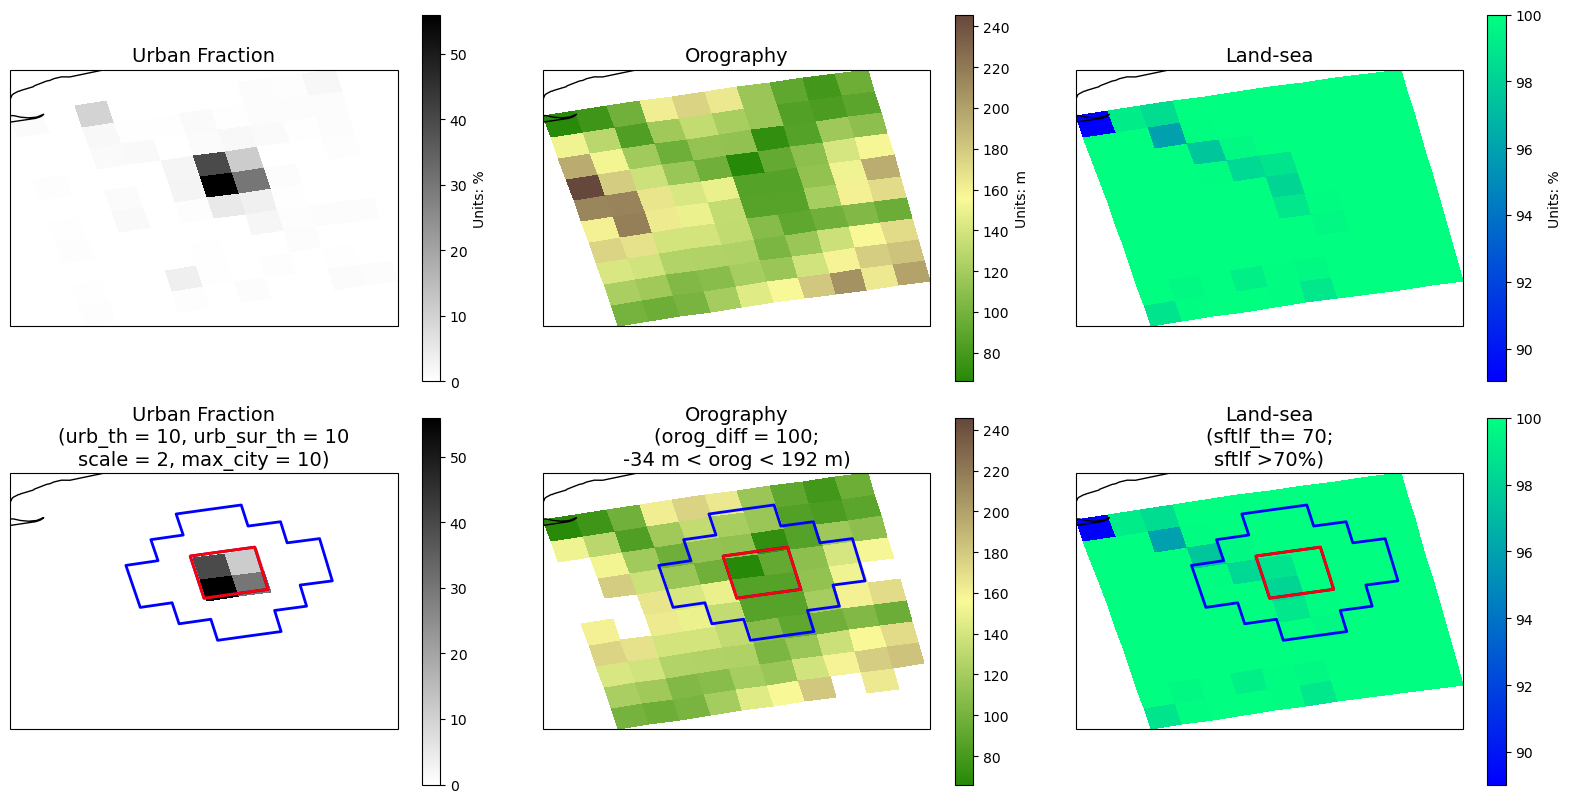

In [34]:
fig = URBAN.plot_static_variables(ds_sfturf = ds_sfturf, 
                                  ds_orog = ds_orog, 
                                  ds_sftlf = ds_sftlf,
                                  sfturf_mask = sfturf_mask, 
                                  orog_mask = orog_mask, 
                                  sftlf_mask = sftlf_mask,
                                  urban_areas = urmask)
fig.savefig(f"{output_dir}/masks_{base_filename}.pdf", bbox_inches='tight')

Save these masks and urban fraction to NetCDF

In [31]:
urmask.to_netcdf(f"{output_dir}/urmask-{urban_var}_{base_filename}_fx.nc")

## Calculate Urban Heat Island (UHI)

### Load climate variable

In [36]:
files_pattern = f"{root_esgf}{domain}/{RCM_DICT[domain][model].split('_')[0]}/*/{scenario}/*/{RCM_DICT[domain][model].split('_')[1]}/*/day/{variable}/*/{variable}_*.nc"
files = glob.glob(files_pattern)
ds_RCM = xr.open_mfdataset(sorted(files), combine='nested', concat_dim='time')

In [37]:
ds_RCM = kelvin2degC(ds_RCM, variable)
ds_RCM = fix_360_longitudes(ds_RCM)
ds_RCM = URBAN.crop_area_city(ds = ds_RCM, res = domain_resolution)

### Load city shapefile

In [38]:
root_nextcloud = '/lustre/gmeteo/WORK/DATA/CORDEX-FPS-URB-RCC/nextcloud/CORDEX-CORE-WG/'
ucdb_city = load_ucdb_city(root_nextcloud, city)

### Load observations

In [ ]:
radious = 0.5
GHCNd = load_ghcnd_stations(lon_city, lat_city, radious = 0.5)

### Select coincident period between Model and Observations

In [ ]:
valid_obs, time_series_obs, ds_RCM_period = get_valid_timeseries(
    city, GHCNd, ds_RCM, variable, idate='1979-01-01', fdate='2014-12-31', divide= 1
)

#### Calculate observations both inside and outside the city

In [ ]:
valid_obs = inside_city(valid_obs, ucdb_city)

### Compute the annual cycle climatology of anomalies with respect to rural vicinity mean

In [42]:
if valid_obs == []:
    valid_obs = pd.DataFrame()
    time_series_obs = pd.DataFrame()

In [43]:
UHI = UrbanIsland(
    ds = ds_RCM_period[variable],
    urban_vicinity = urmask,
    anomaly = 'abs',
    obs_attributes = valid_obs,
    obs_timeseries = time_series_obs
)

## Plot the data

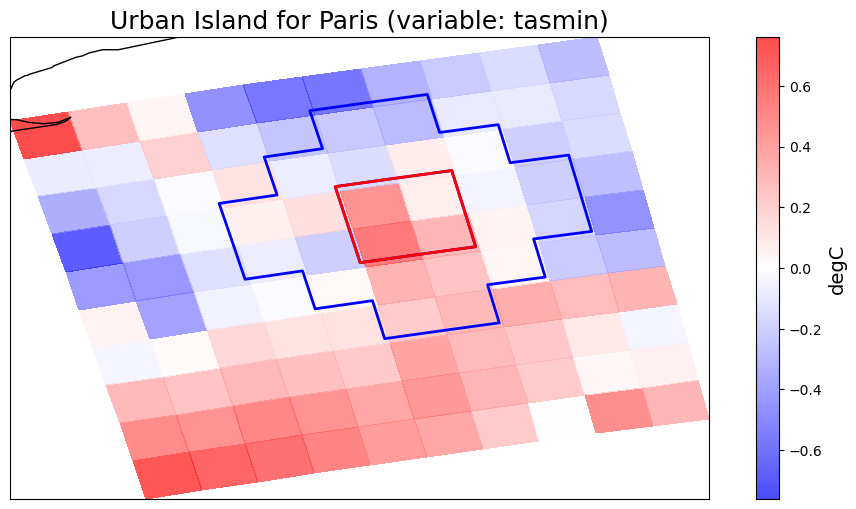

In [44]:
fig = UHI.plot_UI_map(
    city_name = city,
)
fig.savefig(f"{output_dir}/{variable}_{base_filename}_map-anom-wrt-rural.pdf", bbox_inches='tight')

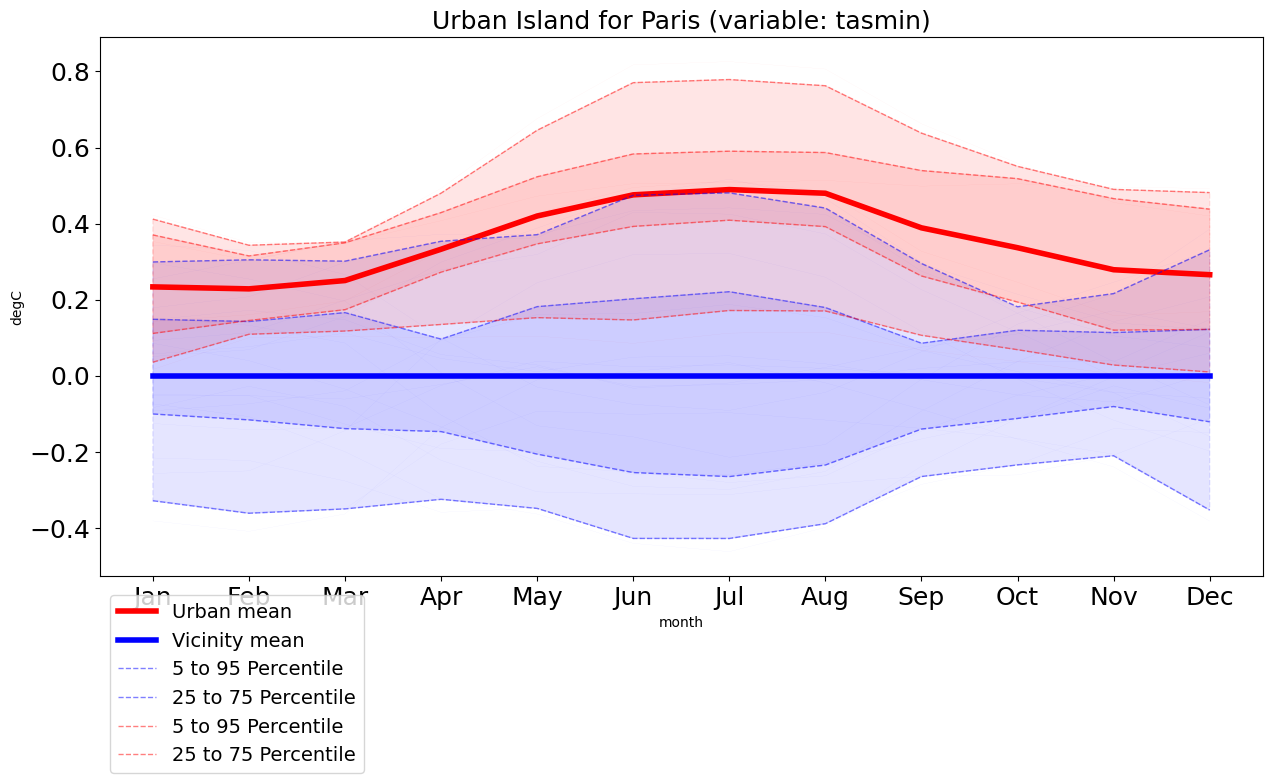

In [45]:
fig = UHI.plot_UI_annual_cycle(
    percentiles = [5,25],
    gridcell_series = True, 
    city_name = city)